In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob

In [2]:
path = 'H:/Documents/Training/Thinkful'
os.chdir(path)

In [3]:
d = pd.read_csv('epi_r.csv', encoding='ISO 8859-1')

In [4]:
md = pd.DataFrame({
    'nulls': d.apply(lambda x: x.isna().sum()),
    'd_types': d.dtypes,
    'levels': d.apply(lambda x: len(x.drop_duplicates()))
})

In [5]:
d.columns[d.columns.str.contains('rating')]

Index(['rating'], dtype='object')

# Create binary variable

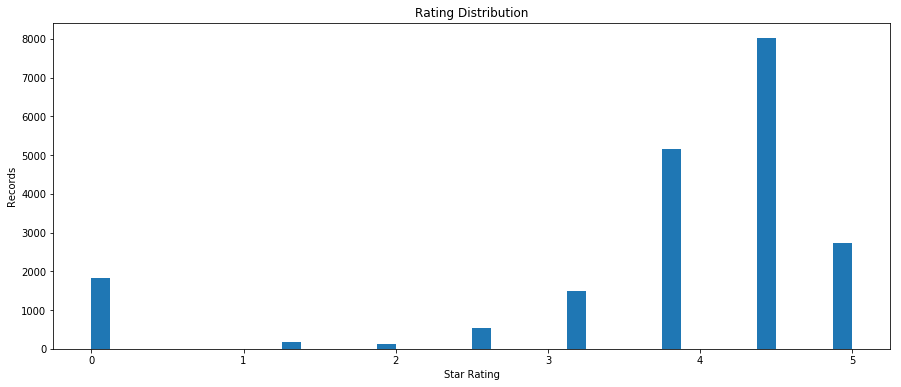

In [6]:
f, ax = plt.subplots(figsize=(15, 6))
ax.hist(d.rating, bins=40)
plt.title('Rating Distribution')
plt.xlabel('Star Rating')
plt.ylabel('Records')
plt.show()

In [7]:
d.rating.value_counts()

4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: rating, dtype: int64

It looks like our data clusters between 3.75 and 5, with fewer values that are sub-optimal. However, if I were a recipe writer, I would be interested in higher than average values. Therefore, I will define success as 4.375 and above as success (target=1) and values lower than 4.375 as failure (target=0). This has the advantage of having roughly balanced groups. However, with the data clustered between 3.75 and 5 there is a good chance that the data may not split cleanly <4 and over 4.

In [9]:
d['target'] = np.where(d.rating>4, 1, 0)

In [10]:
X_bin = d[md.loc[md.levels==2].index]
y = d.target

# Feature Selection via Random Forest

In [11]:
from sklearn.ensemble import ExtraTreesClassifier as etc

cls = etc(n_estimators=250, max_depth=4, n_jobs=-1)
cls.fit(X_bin, y)
importances = cls.feature_importances_

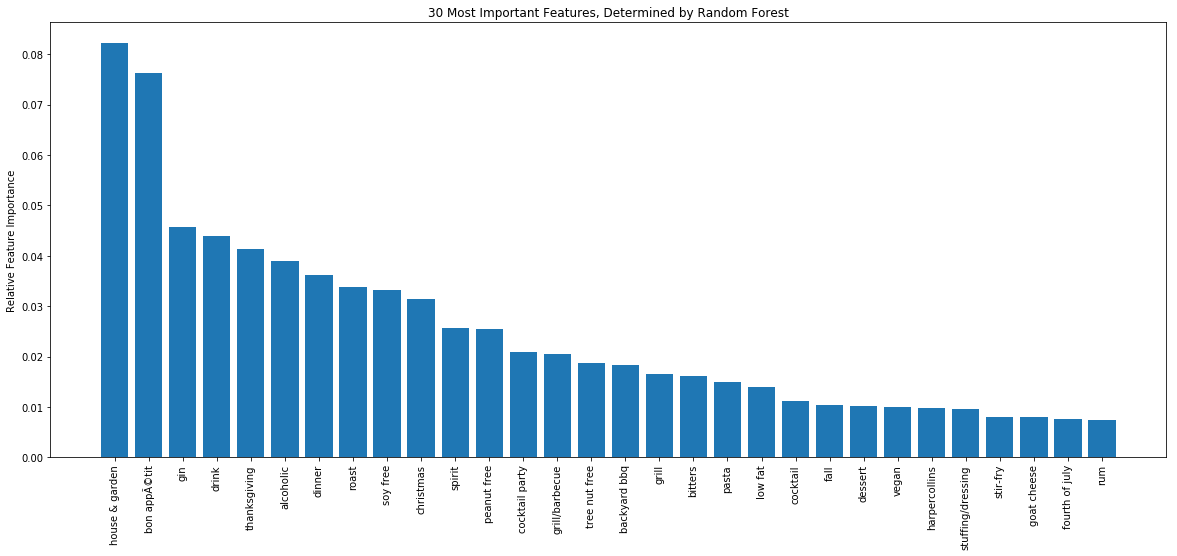

In [12]:
bdata = pd.Series(importances, index=X_bin.columns).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(20, 8))
ax.bar(bdata.index[:30], bdata[:30])
plt.title('30 Most Important Features, Determined by Random Forest')
plt.ylabel('Relative Feature Importance')
plt.xticks(rotation=90)
plt.show()

Random forest can bias towards less sparse variables. I'm curious to see the relationship between feature importance and mean value. Since all features included were binary, mean will serve as a proxy for distribution.

In [13]:
imp_dist = pd.DataFrame(bdata, columns=['feature_importance'])
imp_dist['field_mean'] = d[imp_dist.index].apply(np.mean)

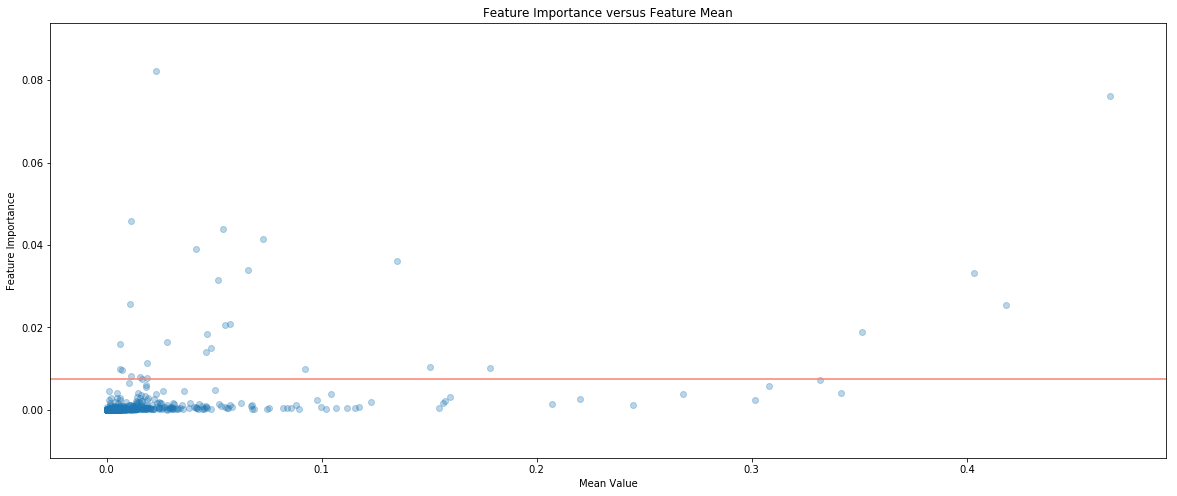

In [14]:
f, ax = plt.subplots(figsize=(20, 8))
ax.scatter(imp_dist.field_mean, imp_dist.feature_importance, alpha=0.3)
ax.axhline(imp_dist.sort_values('feature_importance', ascending=False).iloc[29]['feature_importance'], color='salmon')
plt.title('Feature Importance versus Feature Mean')
plt.ylabel('Feature Importance')
plt.xlabel('Mean Value')
plt.show()

In [15]:
f30 = imp_dist.sort_values('feature_importance', ascending=False)[:30].index

In [16]:
from sklearn.svm import SVC as svc
from sklearn.model_selection import cross_val_score as cvs
from time import perf_counter

c = (0.01, 0.1, 10, 100, 1000)

X = d[f30]
y=d.target

# SVM Model 1: Building a SVM classifier with RBF kernel

In [130]:
start = perf_counter()
cls = svc(C=c[0], kernel='rbf', gamma='auto')
scores = cvs(cls, X, y, cv=3, n_jobs=-1)
end = perf_counter()

print('Elapsed time: {0:.2f} seconds'.format(end-start))

print('\nAverage accuracy for three trials: {0:.3f}'.format(np.mean(scores)))
print('Standard deviation for three trials: {0:.3f}'.format(np.std(scores)))

Elapsed time: 43.13 seconds

Average accuracy for three trials: 0.557
Standard deviation for three trials: 0.001


In [131]:
c = (0.01, 10, 100, 1000)

X = d[f30]
y=d.target

for i in c:
    start = perf_counter()
    cls = svc(C=i, kernel='rbf', gamma='auto')
    scores = cvs(cls, X, y, cv=3, n_jobs=-1)
    end = perf_counter()

    print('\nElapsed time: {0:.2f} seconds'.format(end-start))
    print('Average accuracy for three trials: {0:.3f}'.format(np.mean(scores)))
    print('Standard deviation for three trials: {0:.3f}'.format(np.std(scores)))

Elapsed time: 39.75 seconds

Average accuracy for three trials: 0.536
Standard deviation for three trials: 0.000
Elapsed time: 36.65 seconds

Average accuracy for three trials: 0.579
Standard deviation for three trials: 0.002
Elapsed time: 58.68 seconds

Average accuracy for three trials: 0.582
Standard deviation for three trials: 0.003
Elapsed time: 229.24 seconds

Average accuracy for three trials: 0.579
Standard deviation for three trials: 0.003


In [133]:
svm_results = pd.DataFrame({'c_value': [0.1, 0.01, 10, 100, 1000],
                        'acc_mean': [0.557, 0.536, 0.579, 0.582, 0.579],
                        'acc_std': [0.001, 0.000, 0.002, 0.003, 0.003]
                       })

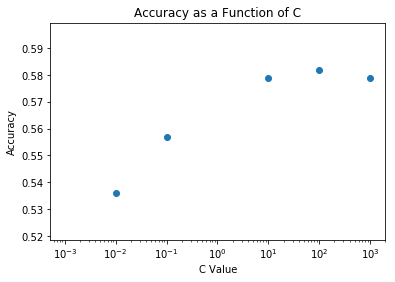

In [140]:
plt.scatter(svm_results.c_value, svm_results.acc_mean)
plt.title('Accuracy as a Function of C')
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.show()

# Model 2: Changing the kernel
## Polynomial kernel, degree=3

In [19]:
start = perf_counter()
c = 100
cls = svc(C=c, kernel='poly', gamma='auto', degree=3)
scores = cvs(cls, X, y, cv=3, n_jobs=-1)
end = perf_counter()


In [20]:
print('Time elapsed: {0:,} seconds'.format(end-start))
print('Average accuracy for C of {0}: {1:.3%}'.format(c, scores.mean()))

Time elapsed: 35.325173334000056 seconds
Average accuracy for C of 100: 56.538%


In [23]:
for i in (0.01, 0.1, 1, 10, 1000):
    cls = svc(C=i, kernel='poly', degree=3)
    start=perf_counter()
    scores = cvs(cls, X, y, cv=3, n_jobs=-1)
    end = perf_counter()
    
    print('Time elapsed, C={0}: {1:.2f} seconds'.format(i, end-start))
    print('Average accuracy, C={0}: {1:.3f}'.format(i, scores.mean()))
    print('Standard deviation of accuracy, C={0}: {1:.3f}\n'.format(i, scores.std()))
    

Time elapsed, C=0.01: 34.94 seconds
Average accuracy, C=0.01: 0.536
Standard deviation of accuracy, C=0.01: 0.000

Time elapsed, C=0.1: 38.59 seconds
Average accuracy, C=0.1: 0.536
Standard deviation of accuracy, C=0.1: 0.000

Time elapsed, C=1: 34.98 seconds
Average accuracy, C=1: 0.536
Standard deviation of accuracy, C=1: 0.000

Time elapsed, C=10: 32.15 seconds
Average accuracy, C=10: 0.548
Standard deviation of accuracy, C=10: 0.002

Time elapsed, C=1000: 34.40 seconds
Average accuracy, C=1000: 0.581
Standard deviation of accuracy, C=1000: 0.004



## Linear kernel

In [24]:
for i in (0.01, 0.1, 1, 10, 100, 1000):
    cls = svc(C=i, kernel='linear')
    start=perf_counter()
    scores = cvs(cls, X, y, cv=3, n_jobs=-1)
    end = perf_counter()
    
    print('Time elapsed, C={0}: {1:.2f} seconds'.format(i, end-start))
    print('Average accuracy, C={0}: {1:.3f}'.format(i, scores.mean()))
    print('Standard deviation of accuracy, C={0}: {1:.3f}\n'.format(i, scores.std()))

Time elapsed, C=0.01: 27.30 seconds
Average accuracy, C=0.01: 0.564
Standard deviation of accuracy, C=0.01: 0.003

Time elapsed, C=0.1: 27.94 seconds
Average accuracy, C=0.1: 0.566
Standard deviation of accuracy, C=0.1: 0.007

Time elapsed, C=1: 27.53 seconds
Average accuracy, C=1: 0.568
Standard deviation of accuracy, C=1: 0.007

Time elapsed, C=10: 32.04 seconds
Average accuracy, C=10: 0.568
Standard deviation of accuracy, C=10: 0.006

Time elapsed, C=100: 57.72 seconds
Average accuracy, C=100: 0.568
Standard deviation of accuracy, C=100: 0.006

Time elapsed, C=1000: 276.47 seconds
Average accuracy, C=1000: 0.568
Standard deviation of accuracy, C=1000: 0.006



## Sigmoid kernel

In [26]:
for i in (0.01, 0.1, 1, 10, 100, 1000):
    cls = svc(C=i, kernel='sigmoid')
    start=perf_counter()
    scores = cvs(cls, X, y, cv=3, n_jobs=-1)
    end = perf_counter()
    
    print('Time elapsed, C={0}: {1:.2f} seconds'.format(i, end-start))
    print('Average accuracy, C={0}: {1:.3f}'.format(i, scores.mean()))
    print('Standard deviation of accuracy, C={0}: {1:.3f}\n'.format(i, scores.std()))

Time elapsed, C=0.01: 45.45 seconds
Average accuracy, C=0.01: 0.536
Standard deviation of accuracy, C=0.01: 0.000

Time elapsed, C=0.1: 38.86 seconds
Average accuracy, C=0.1: 0.550
Standard deviation of accuracy, C=0.1: 0.001

Time elapsed, C=1: 34.48 seconds
Average accuracy, C=1: 0.567
Standard deviation of accuracy, C=1: 0.006

Time elapsed, C=10: 48.12 seconds
Average accuracy, C=10: 0.563
Standard deviation of accuracy, C=10: 0.004

Time elapsed, C=100: 48.72 seconds
Average accuracy, C=100: 0.525
Standard deviation of accuracy, C=100: 0.010

Time elapsed, C=1000: 42.25 seconds
Average accuracy, C=1000: 0.520
Standard deviation of accuracy, C=1000: 0.005



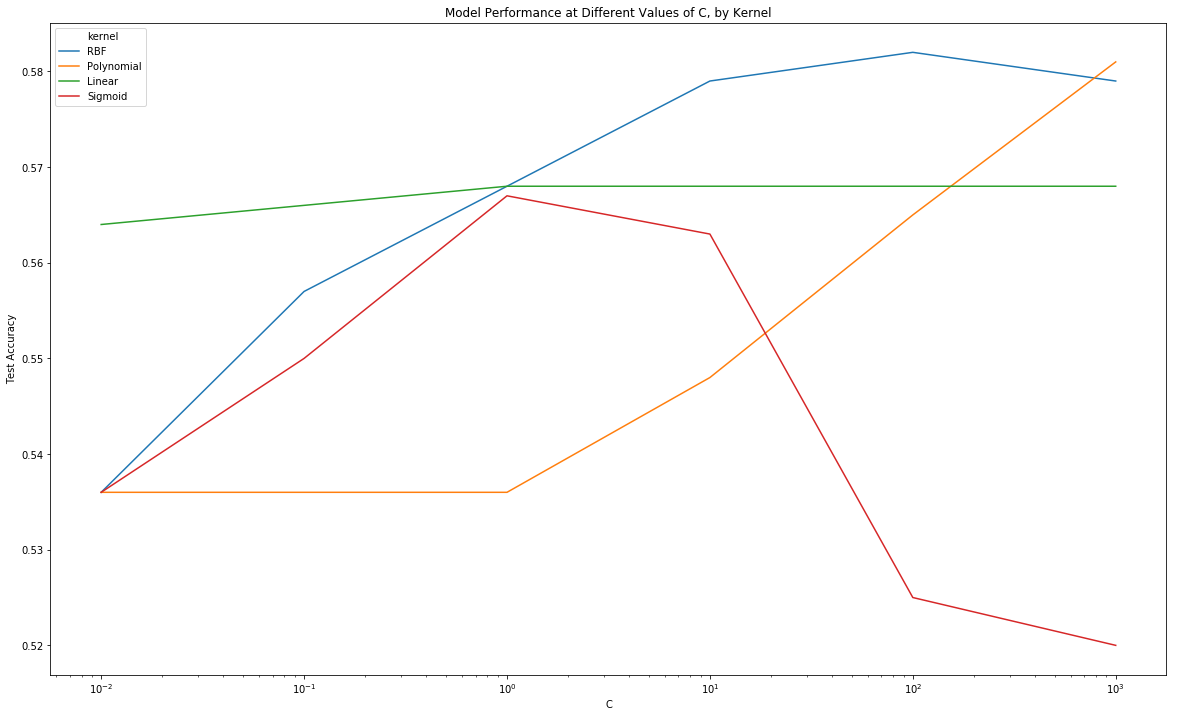

In [32]:
scores = pd.read_csv('H:/Documents/Training/Thinkful/svm_scores.csv')

f, ax = plt.subplots(figsize=(20, 12))
sns.lineplot('c', 'acc_mean', hue='kernel', data=scores, ax=ax)
plt.xscale('log')
plt.title('Model Performance at Different Values of C, by Kernel')
plt.xlabel('C')
plt.ylabel('Test Accuracy')
plt.show()

# Conclusion
Changing the kernel and C didn't significantly change performance. It's possible the features are just lousy. In an interesting turn of events, each kernel seemed to have a different optimal value for C:
- RBF: C=100;
- Polynomial: C=1000;
- Linear: accuracy peaked and remained constant 10-1000; and
- Sigmoid: C=1.